# Predicting Customer Churn using neural net with FastAI

## Inspiration

This notebook is inspired from [Why you should use a framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework) notebook by Jeremy Howard. It focuses on implementing neural net using frameworks like fastai and PyTorch to predict survival on the Titanic Dataset.

The Titanic dataset on kaggle is a beginner-friendly dataset used to predict passenger survival based on input features like age, fare, cabin and pclass. It is a binary classification problem, where the model outputs 0 (did not survive) or 1 (survived)





## Introduction

I have applied some concepts which I learned from the above notebook to the [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) dataset. The dataset consists of 21 columns and 7043 rows where each row represents a customer. Few of the features (columns) are listed below-

* `gender`: Male or Female
* `seniorCitizen`: whether the customer is senior citizen (1) or not (0)
* `Partner`: whether the customer has a partner (Yes) or not (No)
* `Dependents`: whether the customer has dependents (Yes) or not (No)
* `PhoneService`: whether the customer has a phone service (Yes) or not (No)

    and 16 more
* `Churn`: whether the customer has churned (Yes) or not (No)

Thus, there are 20 independent feature (five of which are listed above), and 1 dependent feature- `Churn` which indicates if the customer churned or not.

## Importing basic libraries

We'll start with importing basic libraries and saving path to the csv file.

* `Path` - Makes it easy to work with file and folder paths using simple, readable syntax
* `os` - Lets your code interact with the operating system- like creating folders or listing files
* `fastai.tabular.all` - Loads all FastAI tools for working with structured (tabular) data, including models and data loaders

We'll set `path` to point to the `telco-customer-churn` folder, which contains the dataset (CSV file) for analysis.

In [1]:
from pathlib import Path
import os

path = Path('../input/telco-customer-churn')
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00


Setting the `display format` for floating-point numbers to 2 decimal places in pandas, and random seed to ensure consistent results

In [2]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

Adjusting the `display settings` for NumPy, PyTorch, and pandas to show longer lines and limiting scientific notation for easier readability

In [3]:
import numpy as np

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [4]:
!ls {path}

WA_Fn-UseC_-Telco-Customer-Churn.csv


## Preparing the DataFrame

We'll import the CSV file into a Pandas DataFrame and display the first few rows

In [5]:
full_df = pd.read_csv(path/'WA_Fn-UseC_-Telco-Customer-Churn.csv')
full_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We'll set 10% of the rows aside for the `test set` to make sure the model makes its final predictions on entirely new data which is not part of the training process

In [6]:
test_size = int(0.10 * len(full_df))

df = full_df.iloc[:-test_size].copy()
test_df = full_df.iloc[-test_size:].copy()

In [7]:
len(df), len(test_df)

(6339, 704)

## Feature Engineering

Below output shows us that dataset doesn't contain any null values

In [8]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Displaying `summary statistics` (like count, unique values, top value, and frequency) for numeric columns in the DataFrame.

This helps us to check for any unusually large values that could dominate the results and cause issues in the model.

In [9]:
df.describe(include=(np.number))

,SeniorCitizen,tenure,MonthlyCharges
count,6339.00,6339.00,6339.00
mean,0.16,32.33,64.70
std,0.37,24.59,30.16
min,0.00,0.00,18.25
25%,0.00,9.00,35.10
50%,0.00,29.00,70.40
75%,0.00,55.00,89.85
max,1.00,72.00,118.75


From the above summary, it looke like none of the numerical columns contain exceptionally large values.

In [10]:
df.SeniorCitizen.unique()

array([0, 1])

In a similar way, we can display summary statistics for non-numerical columns in the DataFrame.

In [11]:
df.describe(include=[object])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339,6339
unique,6339,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,5906,2
top,2081-KJSQF,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3198,3279,4458,5739,3059,2787,3132,2780,2770,3133,2526,2484,3495,3745,2130,10,4665


From the summary of non-numeric columns, it appears that each row has a unique value for `customerID`, so we can likely exclude this field from model training.

On the other hand, other non-numeric fields such as **gender**, **Partner**, **Dependents**, and **PhoneService**, which contain 2-3 categories, should be converted into integer categories because string values can't be multiplied by coefficients.

Additionally, `TotalCharges` seems to have float values stored as strings, so we should convert it to a numeric column to handle any missing values more easily.

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df.describe(include=(np.number)))

       SeniorCitizen  tenure  MonthlyCharges  TotalCharges
count        6339.00 6339.00         6339.00       6330.00
mean            0.16   32.33           64.70       2279.15
std             0.37   24.59           30.16       2269.62
min             0.00    0.00           18.25         18.80
25%             0.00    9.00           35.10        396.48
50%             0.00   29.00           70.40       1395.65
75%             0.00   55.00           89.85       3775.05
max             1.00   72.00          118.75       8684.80


Displaying `unique values` for each non numerical column in the DataFrame

In [13]:
for col in df.select_dtypes(include=[object]).columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print('--' * 20)

Column: customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '8647-SDTWQ' '2696-ECXKC' '2081-KJSQF']
----------------------------------------
Column: gender
['Female' 'Male']
----------------------------------------
Column: Partner
['Yes' 'No']
----------------------------------------
Column: Dependents
['No' 'Yes']
----------------------------------------
Column: PhoneService
['No' 'Yes']
----------------------------------------
Column: MultipleLines
['No phone service' 'No' 'Yes']
----------------------------------------
Column: InternetService
['DSL' 'Fiber optic' 'No']
----------------------------------------
Column: OnlineSecurity
['No' 'Yes' 'No internet service']
----------------------------------------
Column: OnlineBackup
['Yes' 'No' 'No internet service']
----------------------------------------
Column: DeviceProtection
['No' 'Yes' 'No internet service']
----------------------------------------
Column: TechSupport
['No' 'Yes' 'No internet service']
-------------------------

After converting TotalCharges to a numerical feature, we observe that it contains null values. These null values will be addressed when we create the dataloaders in FastAI.

In [14]:
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No


`Splitting the DataFrame` into training and validation sets. Note: The test set is created separately and is not a part of this split.

In [15]:
splits = RandomSplitter(seed=42)(df)

## Preprocessing with dataloaders

We'll categorize the below list of non-numeric features in the DataFrame.

In [16]:
columns_to_categorize=["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", 
              "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
              "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", 
              "PaymentMethod"]

Creating dataloaders from the DataFrame using `TabularPandas`, applying preprocessing (**categorify**, **fill missing**, **normalize**), and setting up categorical/continuous features and target labels for model training.

In [17]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=columns_to_categorize,
    cont_names=["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"],
    y_names="Churn", y_block = CategoryBlock()
).dataloaders(path=".")

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


Creating a tabular learner model with `two hidden layers` of size 14 each and setting accuracy and precision as the evaluation metrics

In [ ]:
from fastai.metrics import accuracy, Precision
learn = tabular_learner(dls, metrics=[accuracy, Precision()], layers=[14,14])

To find the optimal value of learning rate, we can plot a graph that shows `Learning Rate against Loss` and visually highlights the **Slide** and **Valley** points: the optimal learning rate is chosen from the loss value that lies between these two points

SuggestedLRs(slide=0.0691830962896347, valley=0.0063095735386013985)

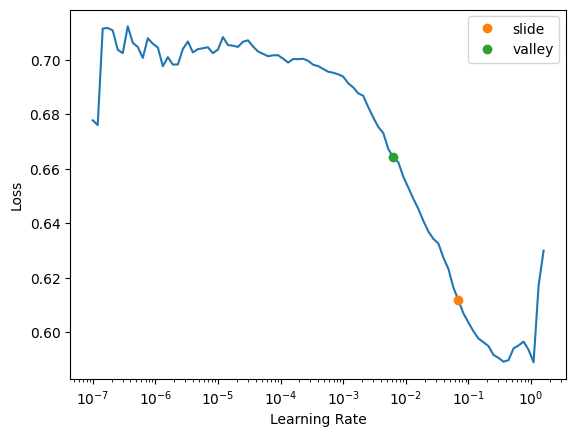

In [19]:
learn.lr_find(suggest_funcs=(slide, valley))

In [20]:
learn.fit(14, lr=0.04)

epoch,train_loss,valid_loss,accuracy,precision_score,time
0,0.431357,0.442946,0.789266,0.583072,00:00
1,0.425288,0.462002,0.775059,0.548747,00:00
2,0.417086,0.444586,0.780584,0.558989,00:00
3,0.416013,0.429233,0.806630,0.658228,00:00
4,0.416253,0.446516,0.783741,0.570122,00:00
5,0.421542,0.434070,0.789266,0.583596,00:00
6,0.424498,0.433680,0.790845,0.612245,00:00
7,0.424855,0.422774,0.798737,0.637131,00:00
8,0.422656,0.432135,0.802684,0.636719,00:00
9,0.425336,0.429134,0.801894,0.619377,00:00


After training the model for 14 iterations, we achieved an accuracy of approximately `0.80`. While there's room to experiment with different hyperparameters, we'll move forward with this model for now and evaluate it on the **test set**.

## Test Set

Repeating the training set preprocessing on the test set, which includes converting `TotalCharges` to a numeric type

In [21]:
test_df['TotalCharges'] = pd.to_numeric(test_df['TotalCharges'], errors='coerce')

Checking if `TotalCharges` contains any null value in the test set

In [22]:
test_df[test_df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


To avoid repeating preprocessing steps like `categorify` and `fill_missing`, we simply load the saved learner and create a test dataloader.

In [23]:
tst_dl = learn.dls.test_dl(test_df)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


## Evaluating our Model

Getting the prediction probabilities (`preds`)for the test data loader `tst_dl` using the trained model `learn`

In [24]:
preds,_ = learn.get_preds(dl=tst_dl)

In [25]:
preds

tensor([[    0.7054,     0.2946],
        [    0.6597,     0.3403],
        [    0.3168,     0.6832],
        [    0.4805,     0.5195],
        [    0.9936,     0.0064],
        [    0.6727,     0.3273],
        [    0.5971,     0.4029],
        ...,
        [    0.8349,     0.1651],
        [    0.9997,     0.0003],
        [    0.8854,     0.1146],
        [    0.8158,     0.1842],
        [    0.6510,     0.3490],
        [    0.2775,     0.7225],
        [    0.9824,     0.0176]])

For each prediction, we select the index of the class with the highest predicted probability (i.e., the predicted class)

In [26]:
pred_index = preds.argmax(dim=1)
pred_index[:10]

tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

Converting the predicted class indices into actual class labels using the vocabulary (`vocab`) from the data loaders.

In [27]:
pred_label = [learn.dls.vocab[i] for i in pred_index]
pred_label[:10]

['No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No']

Extracting the ground truth `Churn` values from the `test_df` DataFrame, to compare with the predicted labels.

In [28]:
true_label = [i for i in test_df['Churn']]
true_label[:10]

['Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No']

In summary, we're using a trained fastai `Learner` to make predictions on a test dataset and map the predictions back to class labels.

Calculating the count of each category `Yes` and `No` from the `Churn` column within the DataFrame. This helps us to identify if the dataset is imbalanced.

In [29]:
print(full_df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


From the above results, we identify that the output column `Churn` contains 5174 values for category `No` and 1869 values for category `Yes`. This tells us that the dataset is imbalanced with many more non-churn labels than churn labels.

In [30]:
from sklearn.metrics import accuracy_score, precision_score

print("Accuracy: ", accuracy_score(true_label, pred_label))

Accuracy:  0.8011363636363636


We prefer calculating precision in this case, because accuracy can be misleading- a model can achieve high accuracy my mostly predicting majority class `No`, ignoring the `Yes` class.

`Precision` tells us- Of all the customers we predicted would churn, how many actually did?

In [31]:
print("Precision: ", precision_score(true_label, pred_label, pos_label='Yes'))

Precision:  0.7131782945736435


Above precision value tells us- out of all customers the model predicted would churn, approx. 71% did churn.

We'll compare this model performance with the `ensembling` approach discussed below.

## Ensembling

This ensemble approach involves training multiple models (in this case `four`), each with a different random seed to introduce variability. Each model is trainied independently on the same data, and their predictions on the `test set` are then averaged to form the final ensemble output. This averaged prediction is used to evaluate the ensemble's overall performance and compared against individual model results.

In [32]:
def ensemble_func():
    learn = tabular_learner(dls, metrics=[accuracy, Precision()], layers=[14, 14])
    with learn.no_bar(), learn.no_logging(): 
        learn.fit(14, lr=0.04)
    e_pred = learn.get_preds(dl=tst_dl)
    return e_pred[0]

In [33]:
learns = [ensemble_func() for i in range(4)]

Averaging the predictions from all models in the ensemble along the first dimension.

In [34]:
en_pred = torch.stack(learns).mean(0)
en_pred[:10]

tensor([[0.6892, 0.3108],
        [0.6460, 0.3540],
        [0.3830, 0.6170],
        [0.4994, 0.5006],
        [0.9640, 0.0360],
        [0.5917, 0.4083],
        [0.5903, 0.4097],
        [0.6814, 0.3186],
        [0.5542, 0.4458],
        [0.6628, 0.3372]])

Selecting the predicted class index with highest average probability for each example.

In [35]:
en_index = en_pred.argmax(dim=1)
en_index[:10]

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

Converting predicted class indices into labels using the model's vocabulary.

In [36]:
en_label = [learn.dls.vocab[i] for i in en_index]
en_label[:10]

['No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No']

Extracting true labels from the test set from the `Churn` column, these will be compared against predicted labels.

In [37]:
en_true = [i for i in test_df['Churn']]
en_true[:10]

['Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No']

In [38]:
print("Accuracy: ", accuracy_score(en_true, en_label))

Accuracy:  0.8082386363636364


In [39]:
print("Precision: ", precision_score(en_true, en_label, pos_label='Yes'))

Precision:  0.7380952380952381


The evaluation metrics show that ensembling approach achieves performance comparable to the deep learning model, with a slightly better precision score, suggesting it can be an effective alternative.